In [71]:
import os
import pyspark
from pyspark.sql import SparkSession, functions as F
import matplotlib.pyplot as plt

os.environ["SPARK_HOME"] = pyspark.__path__[0]
os.environ["PYSPARK_DRIVER_PYTHON"] = "python"
os.environ["PYSPARK_PYTHON"] = "python"

spark = (
    SparkSession.builder
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

levels = spark.read.json("../data/magician_levels_20210521.json", multiLine=True).distinct().cache()
ranking = spark.read.json("../data/magician_ranking_20210521.json", multiLine=True).cache()
exptable = spark.read.csv("../data/exptable.csv", header=True, inferSchema=True).cache()
levels.createOrReplaceTempView("levels")
ranking.createOrReplaceTempView("ranking")
exptable.createOrReplaceTempView("exptable")
levels.printSchema()
ranking.printSchema()
exptable.printSchema()

root
 |-- level: long (nullable = true)
 |-- name: string (nullable = true)
 |-- timestamp: string (nullable = true)

root
 |-- category: string (nullable = true)
 |-- fame: long (nullable = true)
 |-- guild: string (nullable = true)
 |-- job: string (nullable = true)
 |-- level: long (nullable = true)
 |-- mastery: string (nullable = true)
 |-- name: string (nullable = true)
 |-- rank: long (nullable = true)
 |-- specialization: string (nullable = true)
 |-- timestamp: string (nullable = true)

root
 |-- level: integer (nullable = true)
 |-- exp: integer (nullable = true)
 |-- cumulative_exp: long (nullable = true)



In [147]:
df = spark.sql("""
    with specialization as (
        select name, specialization
        from ranking
    ),
    ttl as (
        select
            name,
            level,
            specialization,
            unix_timestamp(from_utc_timestamp(timestamp, "Z"))
                - unix_timestamp(from_utc_timestamp(lag(timestamp) over (partition by name order by level), "Z"))
                as diff
        from levels
        join specialization
        using (name)
    ),
    quantiles as (
        select distinct
            specialization,
            level,
            count(*) over (partition by level, specialization) as n,
            (min(diff) over (partition by level, specialization))/60 as p00,
            (percentile_approx(diff, 0.01) over (partition by level, specialization))/60 as p01,
            (percentile_approx(diff, 0.05) over (partition by level, specialization))/60 as p05,
            (percentile_approx(diff, 0.1) over (partition by level, specialization))/60 as p10,
            (percentile_approx(diff, 0.5) over (partition by level, specialization))/60 as p50
        from ttl
        where diff is not null
        order by 1, 2
    )
    select
        *,
        exp/p00 as epm_p00,
        exp/p01 as epm_p01,
        exp/p05 as epm_p05,
        exp/p10 as epm_p10,
        exp/p50 as epm_p50
    from quantiles
    join exptable
    using (level)
    order by specialization, level
""")
df.show(vertical=True, n=2)

-RECORD 0-----------------------------
 level          | 2                   
 specialization | all                 
 n              | 1                   
 p00            | 0.0                 
 p01            | 0.0                 
 p05            | 0.0                 
 p10            | 0.0                 
 p50            | 0.0                 
 exp            | 34                  
 cumulative_exp | 15                  
 epm_p00        | null                
 epm_p01        | null                
 epm_p05        | null                
 epm_p10        | null                
 epm_p50        | null                
-RECORD 1-----------------------------
 level          | 3                   
 specialization | all                 
 n              | 21118               
 p00            | 0.0                 
 p01            | 0.3333333333333333  
 p05            | 0.48333333333333334 
 p10            | 0.6                 
 p50            | 1.6833333333333333  
 exp            | 57     

In [149]:
pdf = df.toPandas()

In [150]:
pdf.sort_values("p00")

,level,specialization,n,p00,p01,p05,p10,p50,exp,cumulative_exp,epm_p00,epm_p01,epm_p05,epm_p10,epm_p50
14,16,all,11420,-8703.116667,3.166667,6.133333,7.783333,24.133333,8840,27349,-1.015728,2791.578947,1441.304348,1135.760171,366.298343
19,21,all,6192,-7015.083333,6.200000,11.150000,14.233333,43.950000,24402,97841,-3.478505,3935.806452,2188.520179,1714.426230,555.221843
155,52,cleric,9653,-4554.050000,34.633333,48.766667,58.466667,293.183333,789631,8309915,-173.390938,22799.740135,16192.023240,13505.661345,2693.301120
15,17,all,10064,-3641.583333,1.266667,6.650000,8.866667,23.833333,11040,36189,-3.031648,8715.789474,1660.150376,1245.112782,463.216783
553,52,ice,3539,-3347.700000,26.783333,40.800000,55.100000,514.666667,789631,8309915,-235.872689,29482.177971,19353.700980,14330.871143,1534.257124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,195,cleric,64,2087.516667,2087.516667,2896.250000,3621.483333,11906.666667,1624600714,29639900223,778245.625504,778245.625504,560932.486491,448600.908652,136444.628835
295,192,cleric,88,2147.983333,2147.983333,2915.400000,3528.466667,12256.450000,1384319309,25255203036,644473.952622,644473.952622,474829.974961,392328.861167,112946.188252
302,199,cleric,54,2296.933333,2296.933333,2624.350000,2814.100000,9245.316667,2011069705,36692254111,875545.526644,875545.526644,766311.545716,714640.455208,217523.074385
502,200,fire,18,2351.883333,2351.883333,2351.883333,2365.950000,7129.466667,2121276324,38703323816,901947.938461,901947.938461,901947.938461,896585.440943,297536.467057


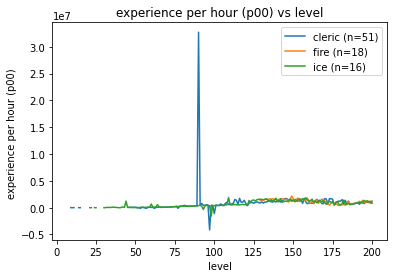

In [153]:
for name in pdf.specialization.unique():
    if name == "all":
        continue
    res = pdf[(pdf.specialization == name)]
    n = res[res.level == res.level.max()].n.values[0]
    plt.plot(res.level, res.epm_p00, label=f"{name} (n={n})")
plt.title("experience per hour (p00) vs level")
plt.xlabel("level")
plt.ylabel("experience per hour (p00) ")
plt.legend()
plt.show()

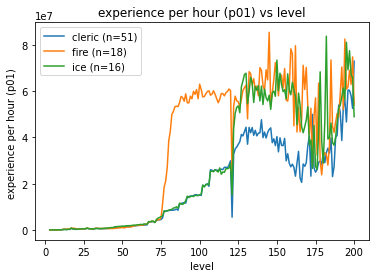

In [76]:
for name in pdf.specialization.unique():
    if name == "all":
        continue
    res = pdf[(pdf.specialization == name)]
    n = res[res.level == res.level.max()].n.values[0]
    plt.plot(res.level, res.epm_p01*60, label=f"{name} (n={n})")
plt.title("experience per hour (p01) vs level")
plt.xlabel("level")
plt.ylabel("experience per hour (p01) ")
plt.legend()
plt.show()

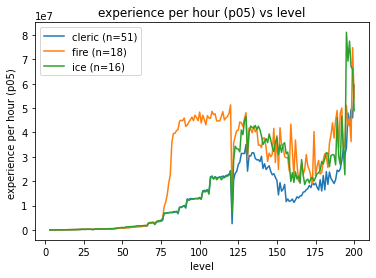

In [155]:
for name in pdf.specialization.unique():
    if name == "all":
        continue
    res = pdf[(pdf.specialization == name)]
    n = res[res.level == res.level.max()].n.values[0]
    plt.plot(res.level, res.epm_p05*60, label=f"{name} (n={n})")
plt.title("experience per hour (p05) vs level")
plt.xlabel("level")
plt.ylabel("experience per hour (p05) ")
plt.legend()
plt.show()

In [80]:
df = spark.sql("""
  with duplicates as (
      select name, level, count(*) as n
      from levels
      group by 1, 2 having n > 1
  )
  select *
  from levels
  join duplicates
  using (name, level)
""")
df.show()
df.count()

+----+-----+---------+---+
|name|level|timestamp|  n|
+----+-----+---------+---+
+----+-----+---------+---+



0

In [84]:
df = spark.sql("""
    with specialization as (
        select name, specialization
        from ranking
    ),
    ttl as (
        select distinct
            name,
            level,
            specialization,
            unix_timestamp(from_utc_timestamp(timestamp, "Z"))
                - unix_timestamp(from_utc_timestamp(lag(timestamp) over (partition by name order by level), "Z"))
                as diff
        from levels
        join specialization
        using (name)
    ),
    anomalous as (
        select * from ttl
        where diff <= 60
        order by diff asc
    )
    select *
    from anomalous
    join (
        select
            *,
            lag(timestamp) over (partition by name order by level) as prev_timestamp
        from levels
    )
    using (name, level)
    order by diff
""")
df.show()

+----------+-----+--------------+-------+-------------------+-------------------+
|      name|level|specialization|   diff|          timestamp|     prev_timestamp|
+----------+-----+--------------+-------+-------------------+-------------------+
|  blehmain|   16|           all|-522187|2017-03-08 13:46:22|2017-03-14 15:49:29|
|Valdebebas|   21|           all|-420905|2017-04-02 00:11:19|2017-04-06 21:06:24|
| SacerBill|   52|        cleric|-273243|2017-03-08 14:17:24|2017-03-11 18:11:27|
|      Aram|   17|           all|-218495|2017-03-07 22:32:13|2017-03-10 11:13:48|
|lordswag69|   52|           ice|-200862|2017-03-07 15:48:08|2017-03-09 23:35:50|
|     Foxed|    8|           all|-149236|2017-04-01 22:14:13|2017-04-03 15:41:29|
| ChillDown|    9|           all|-128753|2017-03-08 19:40:39|2017-03-10 07:26:32|
|  BetaCruz|   12|           all| -94815|2017-03-09 16:38:06|2017-03-10 18:58:21|
| Corgeeees|   31|           ice| -79362|2017-04-02 06:48:02|2017-04-03 04:50:44|
|    Mattyy|    

In [86]:
df.orderBy(F.desc("diff")).show(n=20)

+-----------+-----+--------------+----+-------------------+-------------------+
|       name|level|specialization|diff|          timestamp|     prev_timestamp|
+-----------+-----+--------------+----+-------------------+-------------------+
|    Jotarou|   16|           all|  60|2020-10-11 13:05:04|2020-10-11 13:04:04|
|     Heoink|    3|           ice|  60|2017-06-09 01:34:20|2017-06-09 01:33:20|
|     ImHoly|    3|        cleric|  60|2018-04-27 02:43:16|2018-04-27 02:42:16|
|BeyondShop6|   10|           all|  60|2019-08-13 07:53:59|2019-08-13 07:52:59|
|      Darra|    3|        cleric|  60|2020-06-06 13:55:38|2020-06-06 13:54:38|
|       Ween|    3|        cleric|  60|2021-01-29 22:32:19|2021-01-29 22:31:19|
|   KremePie|    3|        cleric|  60|2018-11-25 05:13:02|2018-11-25 05:12:02|
|    Dearest|   13|           ice|  60|2017-08-30 22:19:10|2017-08-30 22:18:10|
|  TeanForce|    3|           all|  60|2019-06-15 10:32:46|2019-06-15 10:31:46|
|   QueenEli|    3|        cleric|  60|2

In [195]:
df = spark.sql("""
    with specialization as (
        select name, specialization
        from ranking
    ),
    ttl as (
        select
            name,
            level,
            specialization,
            unix_timestamp(from_utc_timestamp(timestamp, "Z"))
                - unix_timestamp(from_utc_timestamp(lag(timestamp) over (partition by name order by level), "Z"))
                as diff
        from levels
        join specialization
        using (name)
    ),
    ttl_norm as (
        select
            name,
            level,
            specialization,
            diff/60 as diff,
            exp/(diff/60) as epm
        from ttl
        left join exptable using (level)
        where diff is not null
            and diff > 0
            -- and (exp/(diff/60)) < 1e7
    ),
    quantiles as (
        select
            specialization,
            level,
            diff,
            count(*) over (partition by level, specialization) as n,
            row_number() over (partition by level, specialization order by diff) as _rank,
            (percentile_approx(diff, 0.05) over (partition by level, specialization)) as p05,
            (percentile_approx(diff, 0.1) over (partition by level, specialization)) as p10,
            (percentile_approx(diff, 0.5) over (partition by level, specialization)) as p50
        from ttl_norm
        order by 1, 2
    ),
    ranked as (
        select
            specialization,
            level,
            n,
            -- can alternatively change this to 2nd but min
            diff as p00,
            p05,
            p10,
            p50
        from quantiles
        where _rank = 1
    )
    select
        *,
        exp/p00 as epm_p00,
        exp/p05 as epm_p05,
        exp/p10 as epm_p10,
        exp/p50 as epm_p50
    from ranked
    left join exptable using (level)
    order by specialization, level
""").cache()
%time df.show(vertical=True, n=3)

-RECORD 0-----------------------------
 level          | 3                   
 specialization | all                 
 n              | 21117               
 p00            | 0.05                
 p05            | 0.48333333333333334 
 p10            | 0.6                 
 p50            | 1.6833333333333333  
 exp            | 57                  
 cumulative_exp | 49                  
 epm_p00        | 1140.0              
 epm_p05        | 117.93103448275862  
 epm_p10        | 95.0                
 epm_p50        | 33.86138613861386   
-RECORD 1-----------------------------
 level          | 4                   
 specialization | all                 
 n              | 21118               
 p00            | 0.23333333333333334 
 p05            | 1.45                
 p10            | 1.6333333333333333  
 p50            | 2.7                 
 exp            | 92                  
 cumulative_exp | 106                 
 epm_p00        | 394.2857142857143   
 epm_p05        | 63.4482

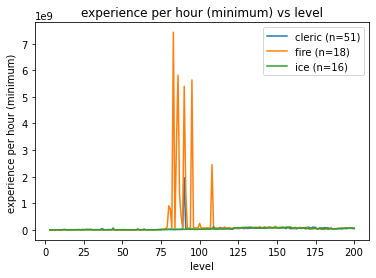

In [210]:
pdf = df.toPandas()
for name in pdf.specialization.unique():
    if name == "all":
        continue
    res = pdf[(pdf.specialization == name)]
    n = res[res.level == res.level.max()].n.values[0]
    plt.plot(res.level, res.epm_p00*60, label=f"{name} (n={n})")
plt.title("experience per hour (minimum) vs level")
plt.xlabel("level")
plt.ylabel("experience per hour (minimum) ")
plt.legend()
# plt.yscale("log")
plt.show()

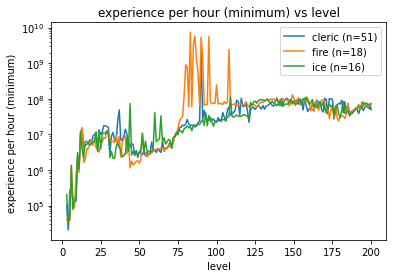

In [206]:
pdf = df.toPandas()
for name in pdf.specialization.unique():
    if name == "all":
        continue
    res = pdf[(pdf.specialization == name)]
    n = res[res.level == res.level.max()].n.values[0]
    plt.plot(res.level, res.epm_p00*60, label=f"{name} (n={n})")
plt.title("experience per hour (minimum) vs level")
plt.xlabel("level")
plt.ylabel("experience per hour (minimum) ")
plt.legend()
plt.yscale("log")
plt.show()

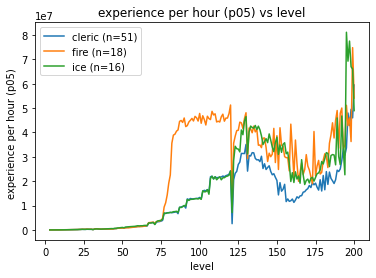

In [208]:
pdf = df.toPandas()
for name in pdf.specialization.unique():
    if name == "all":
        continue
    res = pdf[(pdf.specialization == name)]
    n = res[res.level == res.level.max()].n.values[0]
    plt.plot(res.level, res.epm_p05*60, label=f"{name} (n={n})")
plt.title("experience per hour (p05) vs level")
plt.xlabel("level")
plt.ylabel("experience per hour (p05) ")
plt.legend()
# plt.yscale("log")
plt.show()

# appendix

In [154]:
df = spark.sql("""
    with specialization as (
        select name, specialization
        from ranking
    ),
    ttl as (
        select
            name,
            level,
            specialization,
            unix_timestamp(from_utc_timestamp(timestamp, "Z"))
                - unix_timestamp(from_utc_timestamp(lag(timestamp) over (partition by name order by level), "Z"))
                as diff
        from levels
        join specialization
        using (name)
    ),
    ttl_norm as (
        select
            *,
            (exp/diff)*60 as epm
        from ttl
        left join exptable
        using (level)
        where diff is not null
        and diff > 0
    ),
    -- find outliers in the epm
    medians as (
        select
            percentile_approx(log(diff), 0.5, cast(1e8 as integer)) as median
        from ttl_norm
    ),
    mad as (
        select
            percentile_approx(abs(log(diff) - median), 0.5, cast(1e8 as integer)) as mad
        from ttl_norm
        cross join medians
    ),
    scored as (
        select
            *,
            log(diff) as log_diff,
            (log(diff) - median)/(1.42826 * mad) as zscore
        from ttl_norm
        cross join medians
        cross join mad
    ),
    quantiles as (
        select distinct
            specialization,
            level,
            count(*) over (partition by level, specialization) as n,
            (min(diff) over (partition by level, specialization))/60 as p00,
            (percentile_approx(diff, 0.01) over (partition by level, specialization))/60 as p01,
            (percentile_approx(diff, 0.05) over (partition by level, specialization))/60 as p05,
            (percentile_approx(diff, 0.1) over (partition by level, specialization))/60 as p10,
            (percentile_approx(diff, 0.5) over (partition by level, specialization))/60 as p50
        from ttl
        where diff is not null
        order by 1, 2
    )
    select * from scored order by zscore
""").cache()
%time df.show()

+-----+------------+--------------+----+----+--------------+--------+----------------+------------------+--------+-------------------+
|level|        name|specialization|diff| exp|cumulative_exp|     epm|          median|               mad|log_diff|             zscore|
+-----+------------+--------------+----+----+--------------+--------+----------------+------------------+--------+-------------------+
|   13| ZenoZoldyck|           all|   1|4200|         10639|252000.0|8.39660622842712|1.7119945007591921|     0.0|-3.4339514284605115|
|   12|      Shroom|        cleric|   1|3216|          7423|192960.0|8.39660622842712|1.7119945007591921|     0.0|-3.4339514284605115|
|   12|   soMagical|           all|   1|3216|          7423|192960.0|8.39660622842712|1.7119945007591921|     0.0|-3.4339514284605115|
|   12|       l3Iue|           all|   1|3216|          7423|192960.0|8.39660622842712|1.7119945007591921|     0.0|-3.4339514284605115|
|   12|       tixar|           all|   1|3216|          

array([[<AxesSubplot:title={'center':'zscore'}>]], dtype=object)

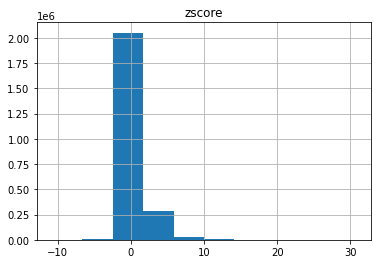

In [125]:
df.select("zscore").toPandas().hist()

(array([  25.,   91.,  127.,  362., 1427., 5087., 3625., 5613., 1942.,
          48.]),
 array([-9.52076618, -8.24797977, -6.97519337, -5.70240696, -4.42962056,
        -3.15683415, -1.88404774, -0.61126134,  0.66152507,  1.93431147,
         3.20709788]),
 <BarContainer object of 10 artists>)

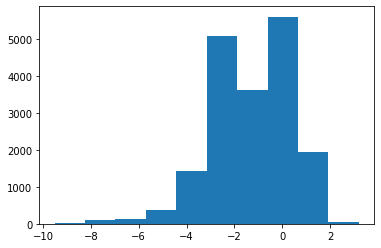

In [118]:
import numpy as np
pdf = df.where("level = 45").toPandas()
plt.hist(np.log(pdf.epm))